# ResNet50 Model Trained with Transfer Learning

This file is used to train a ResNet50 model with transfer learning on the adapted cars dataset (49 classes, images cropped around the bounding boxes, and 50% more training data). 

We used a model with weights pre-trained on the ImageNet dataset.

In [1]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from keras.models import Sequential
from keras.applications import ResNet50
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
IMAGE_SIZE = 224
IMAGE_SHAPE = (224, 224, 3)
classes = 196
seed = 42

train_path = 'C:/Users/Khoi/Downloads/old_data/car_data/car_data/train'
test_path = 'C:/Users/Khoi/Downloads/old_data/car_data/car_data/test'

In [4]:
gen_params = {"rescale":1.0/255,
              "featurewise_center":False,
              "samplewise_center":False,
              "featurewise_std_normalization":False,
              "samplewise_std_normalization":False,
              "zca_whitening":False,
              "rotation_range":20,
              "width_shift_range":0.1,
              "height_shift_range":0.1,
              "shear_range":0.2,
              "zoom_range":0.1,
              "horizontal_flip":True,
              "fill_mode":'constant',
              "cval": 0,
              "validation_split":0.2}

train_datagen = ImageDataGenerator(**gen_params)
test_datagen = ImageDataGenerator(rescale = 1/255.0)

training_set = train_datagen.flow_from_directory(train_path,
                                                  target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                  batch_size = 32,
                                                  class_mode = 'categorical',
                                                  color_mode='rgb',
                                                  shuffle = True,
                                                  subset='training',
                                                  seed=seed)

validation_set = train_datagen.flow_from_directory(train_path,
                                                  target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                  batch_size = 32,
                                                  class_mode = 'categorical',
                                                  color_mode='rgb',
                                                  shuffle =True,
                                                  subset='validation',
                                                  seed=seed)

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            color_mode='rgb',
                                            shuffle =True,
                                            seed=seed)

Found 6598 images belonging to 196 classes.
Found 1546 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.


In [6]:
model_name = "resnet50_cars_2.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name, 
                                             monitor='val_loss',
                                             verbose=0,
                                             save_best_only=True,
                                             save_weights_only=True,
                                             mode='min')

# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%4 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [7]:
base_model = ResNet50(weights='imagenet',
                      input_shape=IMAGE_SHAPE,
                      include_top=False)

In [8]:
base_model.trainable = False
#for layers in base_model.layers[:143]:
    #layer.trainable = False

In [9]:
x = base_model.output
x = Flatten()(x)
prediction = Dense(classes, activation='softmax')(x)

In [10]:
model=Model(inputs=base_model.input, outputs=prediction)

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [12]:
h = model.fit(training_set,
              validation_data = validation_set,
              steps_per_epoch=len(training_set),
              epochs=200,
              verbose=1,
             callbacks=[early_stop, lr_schedule, monitor])

Epoch 1/200
207/207 [==============================] - 145s 700ms/step - loss: 6.0532 - accuracy: 0.0062 - val_loss: 5.9018 - val_accuracy: 0.0071
Epoch 2/200
207/207 [==============================] - 132s 640ms/step - loss: 5.7832 - accuracy: 0.0155 - val_loss: 5.9396 - val_accuracy: 0.0142
Epoch 3/200
207/207 [==============================] - 109s 528ms/step - loss: 5.6863 - accuracy: 0.0203 - val_loss: 5.8618 - val_accuracy: 0.0155
Epoch 4/200
207/207 [==============================] - 106s 512ms/step - loss: 5.6300 - accuracy: 0.0171 - val_loss: 5.9761 - val_accuracy: 0.0116
Epoch 5/200
207/207 [==============================] - 116s 561ms/step - loss: 5.1988 - accuracy: 0.0285 - val_loss: 5.4190 - val_accuracy: 0.0181
Epoch 6/200
207/207 [==============================] - 136s 659ms/step - loss: 5.1465 - accuracy: 0.0306 - val_loss: 5.5279 - val_accuracy: 0.0226
Epoch 7/200
207/207 [==============================] - 107s 518ms/step - loss: 5.1113 - accuracy: 0.0326 - val_loss: 5

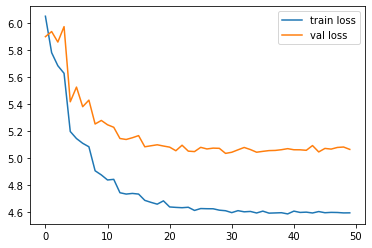

In [13]:
plt.plot(h.history['loss'], label='train loss')
plt.plot(h.history['val_loss'], label='val loss')
plt.legend()
plt.show()

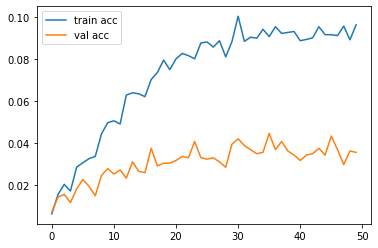

In [14]:
plt.plot(h.history['accuracy'], label='train acc')
plt.plot(h.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [15]:
metrics = model.evaluate(test_set)

252/252 [==============================] - 59s 235ms/step - loss: 4.9585 - accuracy: 0.0480
